# 1. Installation

**1.1 Clone the Repository :**

In [2]:
# Clone the GitHub repository containing the code and resources needed for the project.
!git clone https://github.com/RongWenYin/improved_blora.git

# Change the current working directory to the newly cloned repository folder.
%cd improved_blora

fatal: destination path 'improved_blora' already exists and is not an empty directory.
/kaggle/working/improved_blora


**1.2 Install Dependencies :**

In [7]:
# Install all dependencies listed in the requirements.txt file to ensure the environment has the necessary packages.
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00


**1.3 Initialize Parameters :**

In [4]:
# styleKey should match one of the folder names in the 'images' folder from the GitHub repository.
# styleKey = 'grape'
styleKey = 'dinosaur'

# promptKey sets the specific prompt for generating images or applying styles.
# You can keep the default value "[s90]" as it works universally with this script.
promptKey = "[s90]"

# output_dir defines the directory where the processed or generated outputs will be saved.
# It uses the styleKey to create a unique folder name for each style, like 'outputs_grape'.
output_dir = f'outputs_{styleKey}'


**1.4 Suppress FutureWarning messages (Optional)**

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Train the LoRA within specific blocks only 

**Optional Step** (approximate runtime: 2 hours)  
You may skip this step and proceed to Step 3 to use the pre-trained LoRA model from Hugging Face.


In [5]:
# Launch the training script for fine-tuning the Stable Diffusion XL model with b-Lora.
# This uses the Accelerate library to distribute the training across available resources.

# Using the specified cust_block_list, only the LoRA layers within attention blocks W1 through W6 will be trained.
!accelerate launch train_dreambooth_b-lora_sdxl.py \
    --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
    --instance_data_dir="./images/{styleKey}" \
    --output_dir="{output_dir}" \
    --instance_prompt="{promptKey}" \
    --resolution=1024 \
    --rank=64 \
    --train_batch_size=1 \
    --learning_rate=5e-5 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --max_train_steps=1000 \
    --checkpointing_steps=1000 \
    --seed="0" \
    --gradient_checkpointing \
    --use_8bit_adam \
    --mixed_precision="fp16" \
    --cust_block_list="down_blocks.2.attentions.0 down_blocks.2.attentions.1 mid_block.attentions.0 up_blocks.0.attentions.0 up_blocks.0.attentions.1 up_blocks.0.attentions.2"


/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(*

# 3. Inference of Images Using Improved B-Lora  

**3.1 Import utility functions :**

All functions imported below were written by me and are located in the [GitHub repository](https://github.com/RongWenYin/improved_blora/blob/main/utils.py). These functions are used to generate images with improved B-Lora blocks.


In [8]:
# Import all utility functions and classes from the GitHub repository's utils module
from utils import *

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**3.2 Download or specify the lora model :**

Option 1: Utilize pre-trained LoRA models available on Hugging Face:

In [9]:
# Set the file path for the trained LoRA weights, specifying the repository, file name, and local output directory
style_B_LoRA_path = hf_hub_download(
    repo_id="ElaineYin/loras", 
    filename=f"{styleKey}_all_1000.safetensors", 
    local_dir="loras"
)
print('The style_B_LoRA_path is:', style_B_LoRA_path)

dinosaur_all_1000.safetensors:   0%|          | 0.00/338M [00:00<?, ?B/s]

The style_B_LoRA_path is: loras/dinosaur_all_1000.safetensors


Option 2: Use the LoRA models trained in Step 2 :

In [5]:
# Uncomment the line below to use the LoRA model generated in Step 2 instead of the Hugging Face LoRA file
style_B_LoRA_path = f"{output_dir}/pytorch_lora_weights.safetensors"

**3.3 Specify the object to be generated   :**

In [13]:
# List of object names to be used as prompts for image generation. You may keep the default values:
object_names = ["girl", "cat", "apple", "dog", "fish"]


**3.4 Specify the LoRA blocks to use for image generation :**

Option 1: Use all selected layers combined for a comprehensive style effect (approximate runtime: 3 hours) :

In [ ]:
# Use all selected layers combined for a comprehensive style effect
layer_list = ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 
              'W1_W2', 'W1_W3', 'W1_W4', 'W1_W5', 'W1_W6', 
              'W2_W3', 'W2_W4', 'W2_W5', 'W2_W6', 
              'W3_W4', 'W3_W5', 'W3_W6', 
              'W4_W5', 'W4_W6', 'W5_W6']  # Full range of layer combinations for extensive style customization

 Option 2: Use a subset of layers for testing purposes (approximate runtime: 20 minutes) :

In [9]:
#Uncomment below line below to use subset of layers for image generation with specific style customizations.
# Examples include using combining layers such as 2 and 5, or 4 and 5.
# layer_list = ['W5','W2_W5']  # Layer combinations for style customization

**3.5 Generate images using the SDXL pipeline with the enhanced B-LoRA model :**

The function `inferenceImages`, written by me and located at [this GitHub link](https://github.com/RongWenYin/improved_blora/blob/main/utils.py), is used to generate images with improved B-Lora blocks.


In [10]:
# The inferenceImages function generates images based on a list of object names,
# leveraging the LoRA model to apply specific styles across all combinations of attention blocks from W1 to W6.
inferenceImages(object_names,layer_list,style_B_LoRA_path,promptKey,styleKey)

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Applying Improved B-LoRA to blocks: ['unet.up_blocks.0.attentions.1']
Generating images for [s90] style | W5 layer | 1000 steps


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Applying Improved B-LoRA to blocks: ['unet.down_blocks.2.attentions.1', 'unet.up_blocks.0.attentions.1']
Generating images for [s90] style | W2_W5 layer | 1000 steps


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

**3.6 View Generated Images**: All generated images are saved in the `./improved_blora` folder. The file naming format is:

`<styleKey>__<objectName>__<combinedLayers>__<trainSteps>.png`

For example: `grape__apple__W2_W5__1000.png`


You can view a few pre-generated images by running the code below. *(Note: These images have already been generated and uploaded to the [GitHub repository](https://github.com/RongWenYin/improved_blora/tree/main/outputImages).)*


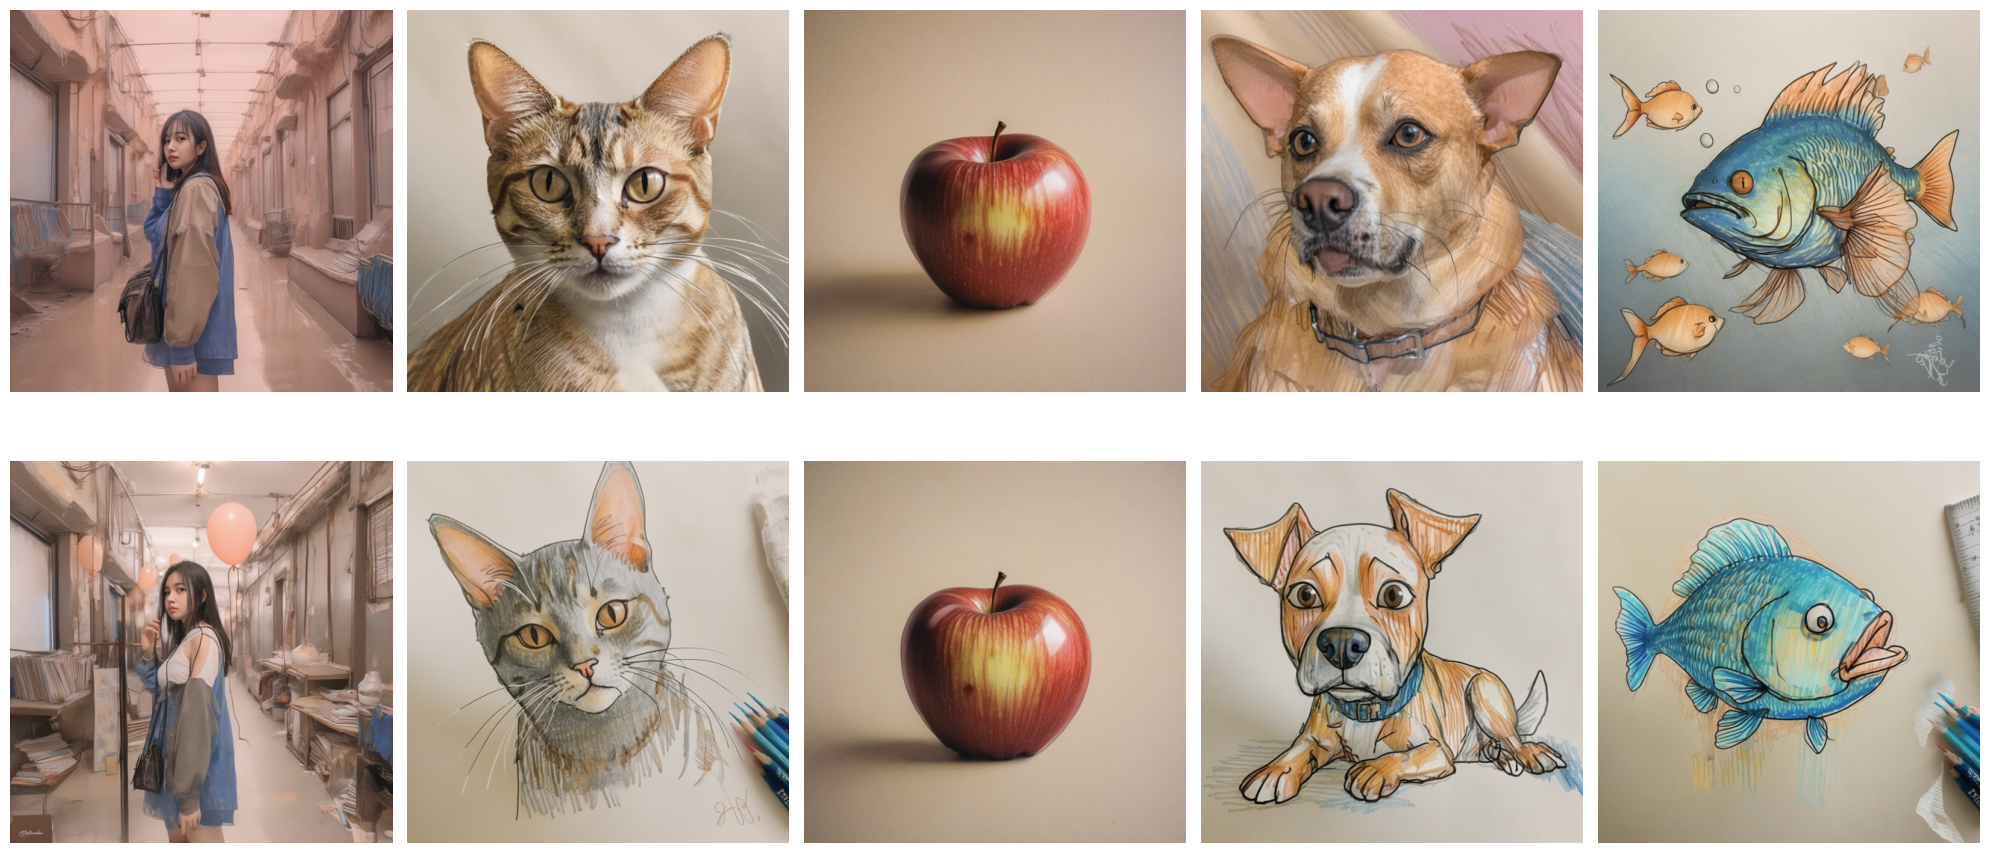

In [17]:
# List of image filenames in the github repor folder
image_filenames = [ 
    f"outputImages/{styleKey}__girl__W5__1000.png",
    f"outputImages/{styleKey}__cat__W5__1000.png",
    f"outputImages/{styleKey}__apple__W5__1000.png",
    f"outputImages/{styleKey}__dog__W5__1000.png", 
    f"outputImages/{styleKey}__fish__W5__1000.png",
    f"outputImages/{styleKey}__girl__W2_W5__1000.png",
    f"outputImages/{styleKey}__cat__W2_W5__1000.png",
    f"outputImages/{styleKey}__apple__W2_W5__1000.png",
    f"outputImages/{styleKey}__dog__W2_W5__1000.png", 
    f"outputImages/{styleKey}__fish__W2_W5__1000.png"
]

displayImages(image_filenames)

# 4. Use InstantStyle to Generate Images for Comparation

**4.1 Download the models used by InstantStyle :**

In [10]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="h94/IP-Adapter", filename="sdxl_models/ip-adapter_sdxl.bin", local_dir="ipadapter")
hf_hub_download(repo_id="h94/IP-Adapter", filename="sdxl_models/image_encoder/config.json", local_dir="ipadapter")
hf_hub_download(repo_id="h94/IP-Adapter", filename="sdxl_models/image_encoder/pytorch_model.bin", local_dir="ipadapter")
hf_hub_download(repo_id="h94/IP-Adapter", filename="sdxl_models/image_encoder/model.safetensors", local_dir="ipadapter")

sdxl_models/image_encoder/config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

'ipadapter/sdxl_models/image_encoder/model.safetensors'

**4.2 Specify the combined layers used by `instantStyle`. You can leave this as the default :**

In [11]:
layer_list_inst=['W5','W2_W5']

**4.3 Generate Images Using InstantStyle:**


In [14]:
# The inferenceImages function generates images for a list of object names using InstantStyle,
# applying specific styles across combinations of attention blocks W2 and W5.
inferenceImagesInst(layer_list_inst, styleKey, object_names)


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W5


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W2_W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W2_W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W2_W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W2_W5


  0%|          | 0/30 [00:00<?, ?it/s]

Done processing layer: W2_W5


**4.4 View All Generated Images**: The images are saved in the `./improved_blora` folder. The file naming format is:

`inst__<styleKey>__<objectName>__<combinedLayers>__<trainSteps>.png`

For example: `inst__grape__apple__W2_W5__1000.png`


You can view a few generated images by running the code below. *(Note: These images have already been generated and uploaded to the same [GitHub repository](https://github.com/RongWenYin/improved_blora/tree/main/outputImages).)*

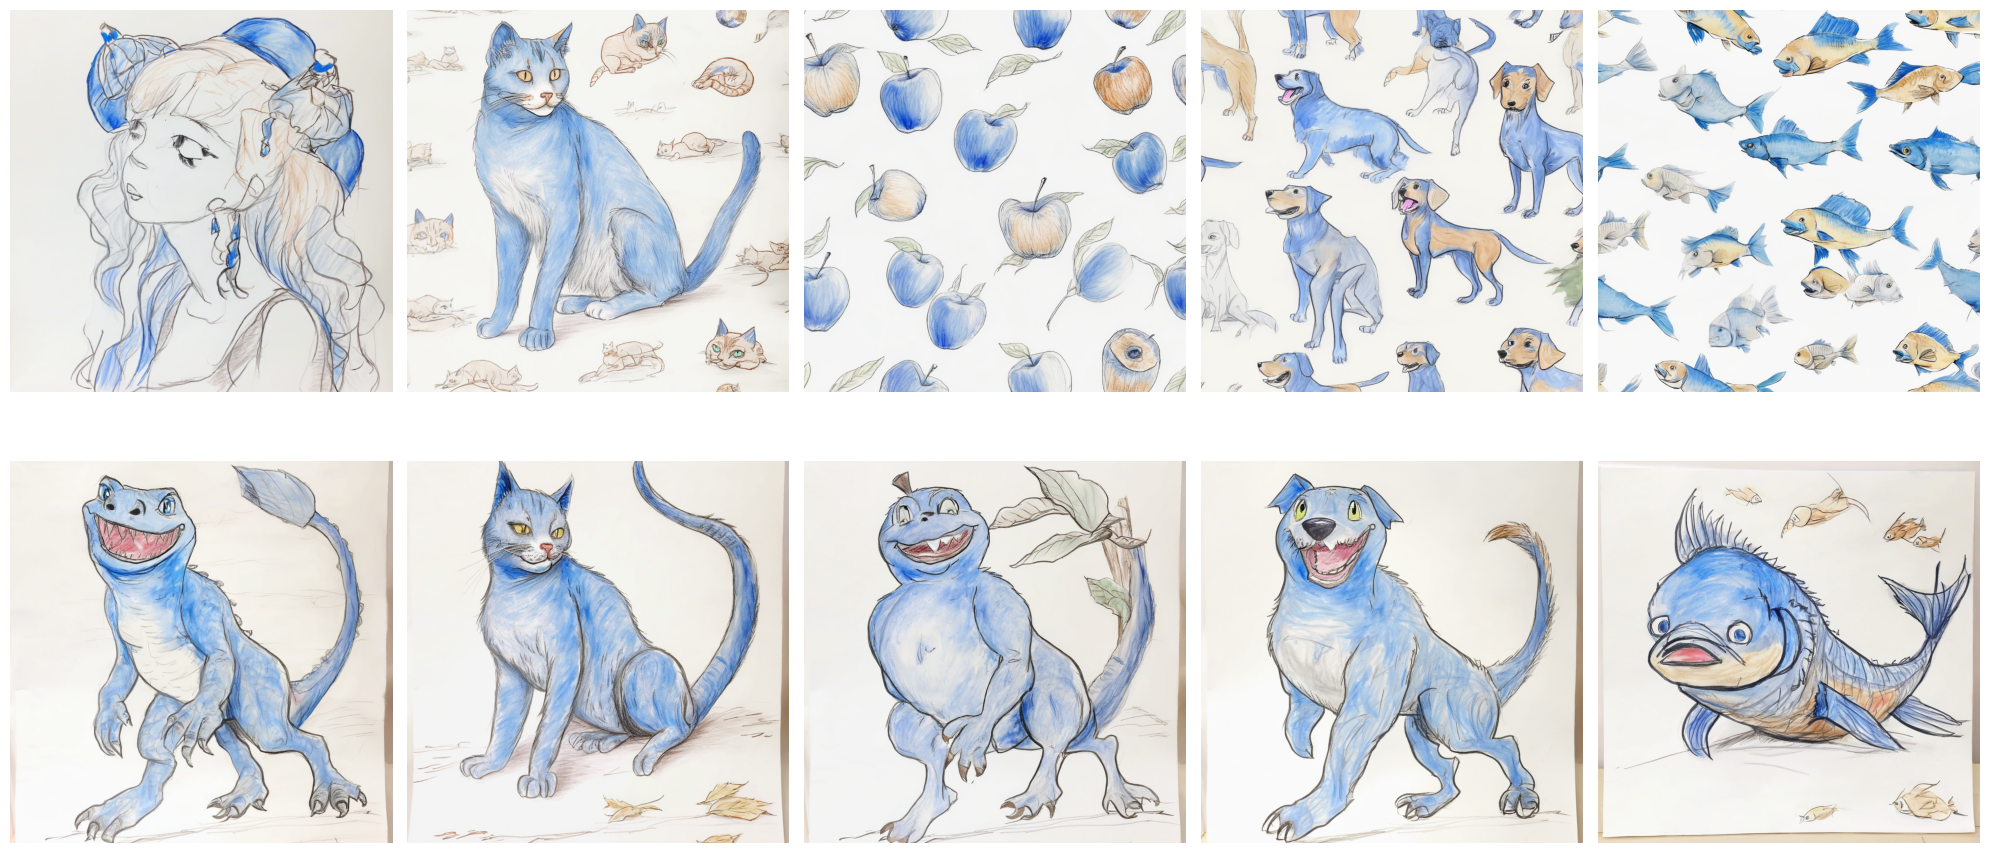

In [18]:
# List of image filenames in the github repor folder
image_filenames = [ 
    f"outputImages/inst__{styleKey}__girl__W5__1000.png",
    f"outputImages/inst__{styleKey}__cat__W5__1000.png",
    f"outputImages/inst__{styleKey}__apple__W5__1000.png",
    f"outputImages/inst__{styleKey}__dog__W5__1000.png", 
    f"outputImages/inst__{styleKey}__fish__W5__1000.png",
    f"outputImages/inst__{styleKey}__girl__W2_W5__1000.png",
    f"outputImages/inst__{styleKey}__cat__W2_W5__1000.png",
    f"outputImages/inst__{styleKey}__apple__W2_W5__1000.png",
    f"outputImages/inst__{styleKey}__dog__W2_W5__1000.png", 
    f"outputImages/inst__{styleKey}__fish__W2_W5__1000.png"
]

displayImages(image_filenames)

# 5. Zip the Images for Download

In [15]:
#Install the Required Dependencies :
!apt-get update
!apt-get install zip -y

# Zip all PNG images into a single zip file and then remove the original images
!zip -j improved_blora_images.zip ./*.png && rm ./*.png

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:8 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [28.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1107 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3392 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1570 kB]
G